# Perceptual Bistability

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')
score = np.array([0., 0.])

## Exercise 1

In [2]:
def heavyside(x): 
    return 1 if x>0 else 0

def laing_chow(y, t, I1, I2): 
    """Implements eqs (1-4) from laing and chow in the format required by scipy.integrate.odeint. 
        y is assumed to be a list [u1, a1, u2, a2]
    """
    # set parameter by default
    alpha, beta = 0.2, 0.4
    g1 = g2 = 1
    phi, tau = 0.4, 20
    u1, a1, u2, a2 = y
    u1dot = -u1 + heavyside(alpha*g1*u1 -beta*g2*u2 -a1 + I1)
    u2dot = -u2 + heavyside(alpha*g2*u2 -beta*g1*u1 -a2 + I2)
    a1dot = 1/tau * (-a1 + phi*heavyside(alpha*g1*u1 -beta*g2*u2 -a1 + I1))
    a2dot = 1/tau * (-a2 + phi*heavyside(alpha*g2*u2 -beta*g1*u1 -a2 + I2))    
    return [u1dot, a1dot, u2dot, a2dot]

def plot_results(sol, t): 
    # get the solution and reproduce the figure
    u1, a1, u2, a2 = sol.T
    plt.figure(figsize=(15, 5))
    plt.suptitle("Solution for the reduced model (1) through (4)", fontsize=16)
    plt.subplot(211)
    plt.plot(t, u1, 'b')
    plt.plot(t, a1, 'g')
    plt.ylim((-.2, 1.2))
    plt.legend(["u1", "a1"])
    plt.subplot(212)
    plt.plot(t, u2, 'b')
    plt.plot(t, a2, 'g')
    plt.ylim((-.2, 1.2))
    plt.legend(["u2", "a2"])
    plt.xlabel("Time"); 

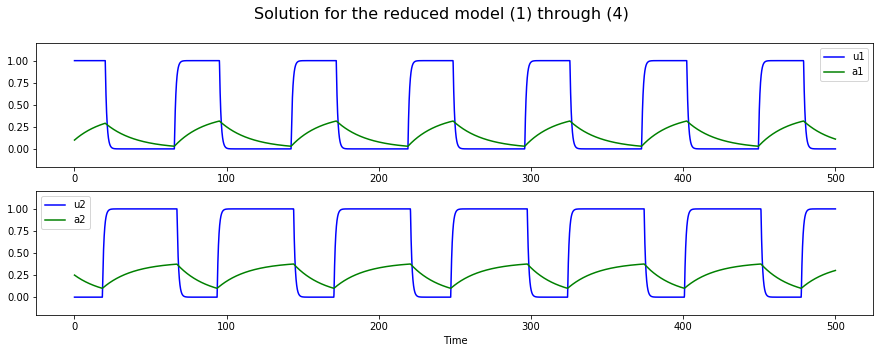

In [3]:
x0 = [1, 0.1, 0, 0.25]
I1, I2 = 0.43, 0.5
t = np.linspace(0,500,5001)
sol = odeint(laing_chow, x0, t, args=(I1, I2))
plot_results(sol, t)

In [4]:
score += [2, 2]; score #

array([2., 2.])

In [5]:
# (b)
def dominance_durations(x1, x2, t): 
    """Calculates the dominant durations of x1 over x2"""
    # get the dominance arrays
    dom = (x1 - (x2))>.1
    # find the shifts
    idx = np.where(np.diff(dom))[0]
    # add shifts at the beginning and end
    shifttimes = np.zeros(len(idx)+2)
    shifttimes[-1] = max(t)
    # add the shift times into the array
    shifttimes[1:-1] = t[idx]
    # who dominated first? 
    x1start = 0 if x1[0]>x2[0] else 1
    return np.diff(shifttimes)[x1start::2]

In [6]:
print(dominance_durations(sol[:,2], sol[:,0], t))

[46.9 48.5 48.5 48.6 48.5 48.5 20.7]


#### Why are the dominance durations different from the analytical T1 (eq. 9) in the paper?
Because these are defined using the exponentially growing and decaying values of a1 and a2 and not, like in our calculations, using the more linear values of u1 and u2. 

In [7]:
score += [2, 2]; score #

array([4., 4.])

In [8]:
# (c) simulate again with different parameters
# default params I1, I2 = 0.43, 0.5
x0 = [1, 0.1, 0, 0.25]
I1 = 0.6 + 0.01
I2 = 0.6 + 0.1
t = np.linspace(0,1000,5001)
sol = odeint(laing_chow, x0, t, args=(I1, I2))

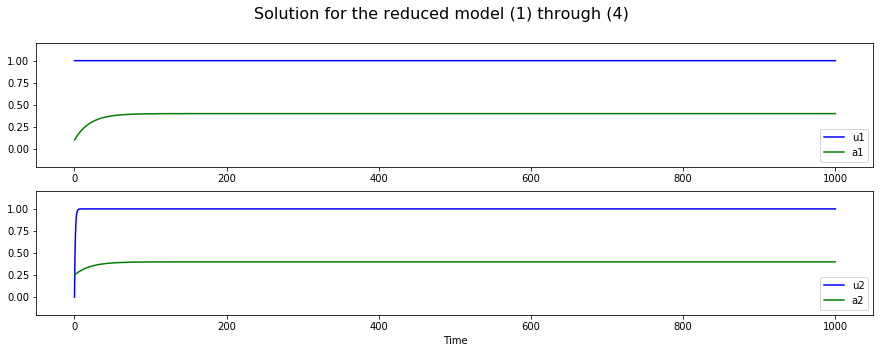

In [9]:
plot_results(sol,t)

Yes, we can confirm that oscillations stop and both populations become active

#### What about intermediate input values?

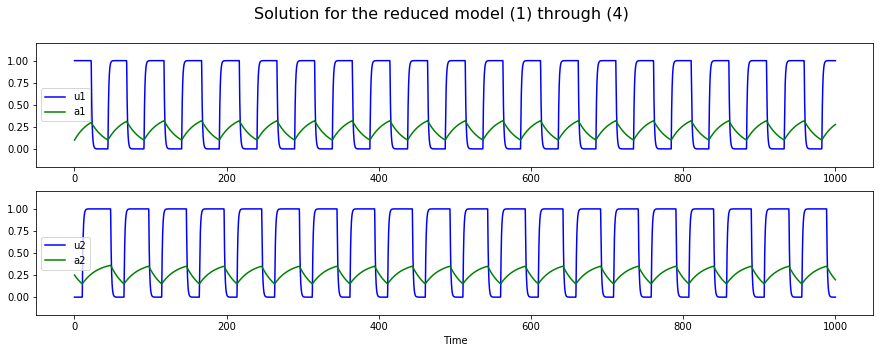

In [10]:
# what about intermediate values. old values I1, I2 = 0.43, 0.5, new values I1, I2 = 0.7, .712
x0 = [1, 0.1, 0, 0.25]
I1 = 0.5
I2 = 0.55 
t = np.linspace(0,1000,5001)
sol = odeint(laing_chow, x0, t, args=(I1, I2))
# plotting
plot_results(sol,t)

In [11]:
print(dominance_durations(sol[:,0], sol[:,2], t))

[12.4 19.6 19.2 19.2 19.2 19.2 19.2 19.2 19.2 19.2 19.2 19.2 19.  19.2
 19.2 19.2 19.2 19.2 19.2 19.2 11.6]


In [12]:
# what is the analytical result for the new input values?
alpha, beta = 0.2, 0.4
phi, tau = 0.4, 20
T1 = -tau * np.log((I2 - beta)/(beta + phi - I1))
print(T1)

13.862943611198906


For intermediate values of I1 and I2 both populations are active at the same time for some periods. So the dominance is not defined properly anymore. We required that $u1>(u2+0.1)$ in order to be dominant. This results in smaller dominance durations. 
#### Do the analytical dominance periods still fit the experimental results? 
They do not fit, the analytical results predict a dominance duration of 2 ms. However, this discrepancy could be due to our new definition of dominance. 
#### How do you interpret these results?
In the first setup adaptation and inhibition of the two populations are balanced, so that only one population is active at a time. 

For the strong inputs the inhibition is too weak to influence the second population, this is why both population are active without oscillations. 

For the intermediate setup we get overlapping periods of activity. This is because the increased input currents increase the adaptation effect as the adaption variables depend on the input currents as well.

In [13]:
score += [2, 2]; score #

array([6., 6.])

## Exercise 2

#### Why can’t you use scipy.integrate.odeint to implement the model in Moreno-Bote et al. (2007)?
Because it involves a stochastic term at the term so that it is not ordinary anymore. 

In [14]:
score += [1, 1]; score # Would appreciate a bit more here

array([7., 7.])

In [15]:
def euler_maruyama(ffun, gfun, x0, t, **args): 
    """Implements Euler Maruyama method for solving system of differential eqs. """
    # get the step size
    dt = t[1]
    # prelocate 
    sqrtdt = np.sqrt(dt)
    f = np.zeros((len(x0), len(t)))
    # set initial values 
    f[:,0] = ffun(x0, t, **args)
    # generate the noise 
    dW = sqrtdt*np.random.standard_normal((len(x0), len(t)))
    # iterate and apply update rule
    for i in range(len(t)-1):        
        f[:,i+1] = f[:,i] + np.array(ffun(f[:,i], t, **args))*dt + np.array(gfun(f[:,i], **args))*dW[:,i]
    # return in the odeint format: results in rows
    return f.T

[27.9 27.8 27.8 27.8 27.8 27.8]


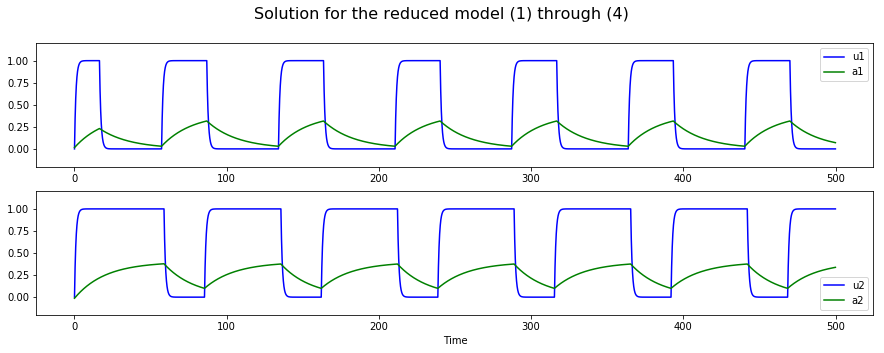

In [16]:
# testing the function using laing_chow
I1, I2 = 0.43, 0.5
x0 = [1, 0.1, 0, 0.25]
t = np.arange(0,500,.1)
sol = euler_maruyama(laing_chow, lambda x, **args: 0, x0, t, **dict([('I1', I1), ('I2', I2)]))
plot_results(sol, t)
print(dominance_durations(sol[:,0], sol[:,2],t))

In [17]:
score += [2, 2]; score #

array([9., 9.])

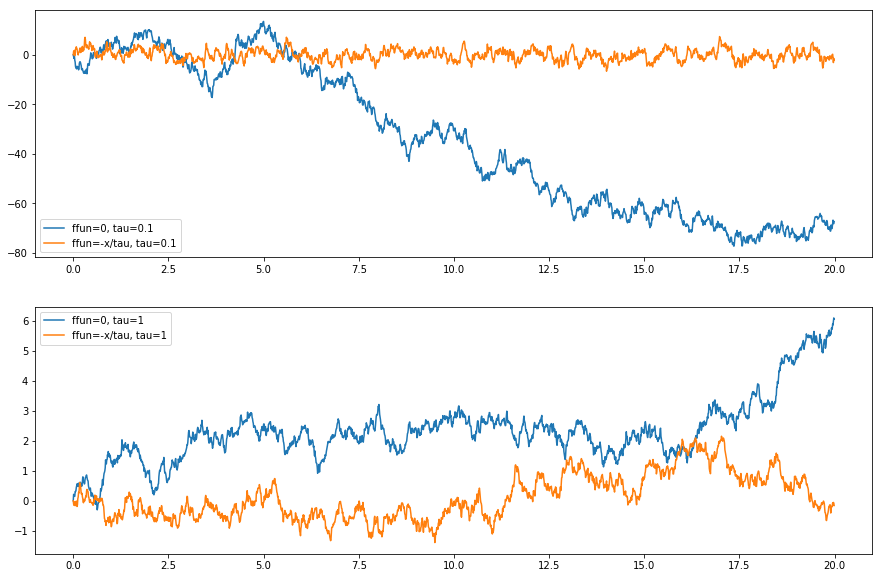

In [18]:
t = np.arange(0, 20, .01)
x0 = [0]
tau1 = 0.1
sol1 = euler_maruyama(lambda x, t: 0, lambda x: 1/tau1, x0, t)
sol2 = euler_maruyama(lambda x, t: -1*np.array(x)/tau1, lambda x: 1/tau1, x0, t)
tau2 = 1
sol3 = euler_maruyama(lambda x, t: 0, lambda x: 1/tau2, x0, t)
sol4 = euler_maruyama(lambda x, t: -1*np.array(x)/tau2, lambda x: 1/tau2, x0, t)
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(t, sol1)
plt.plot(t, sol2)
plt.legend(["ffun=0, tau=0.1", "ffun=-x/tau, tau=0.1"])
plt.subplot(212)
plt.plot(t, sol3)
plt.plot(t, sol4)
plt.legend(["ffun=0, tau=1", "ffun=-x/tau, tau=1"]); 


The two different cases of ffun correspond to two different stochastic processes. For $ffun=0$ we have a Wiener process, also called Brownian motion, while for $ffun=-x/tau$ we have Ornstein-Uhlenbeck process that describes the movement of a Brownian particle under the influence of friction. The friction is introduced by the exponential decay of $x$.

#### What is similar? 
Similarities appear with respect to time scales. Both processes are locally completely stochastic. On both time scales, the Ornstein-process is centered around zero and has less variance. 
#### What is different? 
Differences appear with respect to two processes. The Ornstein-Ohlenbeck process has smaller variance than the Wiener process: The friction lets it decay to zero relatively fast. The complete randomness in the Wiener process lets it drift on longer time scales. However, its expectation value is also zero. 

In [19]:
score += [2, 2]; score #

array([11., 11.])

In [20]:
def f_moreno_bote(y, t, **args): 
    # get current values
    rA, alphaA, nA, rB, alphaB, nB = y
    # calculate parameters 
    val = phi*(rA + rB) + gA + gB
    r_pool = val if val>0 else 0 # rectification 
    rAinh = np.power(r_pool + eta*rA, 2)
    rBinh = np.power(r_pool + eta*rB, 2)
    
    # steps for population A
    rAdot = 1/tau *(-rA + sigmoid(alpha*rA - beta*rAinh + gA - alphaA + nA))
    alphaAdot = 1/tau_a *(-alphaA + gamma*rA)
    nAdot = -nA/tau_s

    # steps for population B    
    rBdot = 1/tau *(-rB + sigmoid(alpha*rB - beta*rBinh + gB - alphaB + nB))
    alphaBdot = 1/tau_b *(-alphaB + gamma*rB)
    nBdot = -nB/tau_s
    return [rAdot, alphaAdot, nAdot, rBdot, alphaBdot, nBdot]
    
def g_moreno_bote(y, **args): 
    noiseterm = sigma*np.sqrt(2/tau_s)
    return [0, 0, noiseterm, 0, 0, noiseterm]

def sigmoid(x, theta=0.1, k=0.05): 
    arg = (x-theta)/k
    return 1/(1+np.exp(-arg))

def plot_moreno_results(sol, t): 
    rA = sol[:,0]
    alphaA = sol[:,1]
    nA = sol[:,2]
    rB = sol[:,3]
    alphaB = sol[:,4]
    nB = sol[:,5]
    val = phi*(rA + rB) + gA + gB
    r_pool = np.array([i if i>0 else 0 for i in val])# rectification 
    rAinh = np.power(r_pool + eta*rA, 2)
    rBinh = np.power(r_pool + eta*rB, 2)
    plt.figure(figsize=(21,10))
    plt.suptitle("Solution of the Moreno Bote model", fontsize=16)
    plt.subplot(311)
    plt.plot(t, rA, 'b')
    plt.plot(t, rB, 'g')
    plt.ylim((-.1, 1.1))
    plt.legend(["rA", "rB"])
    plt.title("Rates")
    plt.subplot(312)
    plt.plot(t, alphaA, 'b')
    plt.plot(t, alphaB, 'g')
    plt.legend(["alphaA", "alphaB"])
    plt.title("Hyperpolarizing currents")
    plt.subplot(313)
    plt.plot(t, nA, 'b')
    plt.plot(t, nB, 'g')
    #plt.ylim((-.2, 1.2))
    plt.legend(["nA", "nB"])
    plt.xlabel("Time")
    plt.title("Noise"); 

def plot_duration_hist(r1, r2): 
    r1dom = dominance_durations(r1, r2, t)
    r2dom = dominance_durations(r2, r1, t)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.hist(r1dom, bins=15)
    plt.legend([ "histogram"])
    plt.title("Dominance durations for rA")
    plt.xlabel("Dominance duration in ms")
    plt.ylabel("Counts")
    plt.subplot(122)
    plt.hist(r2dom, bins=15)
    plt.legend(["histogram"])    
    plt.title("Dominance durations for rB")
    plt.xlabel("Dominance duration in ms");

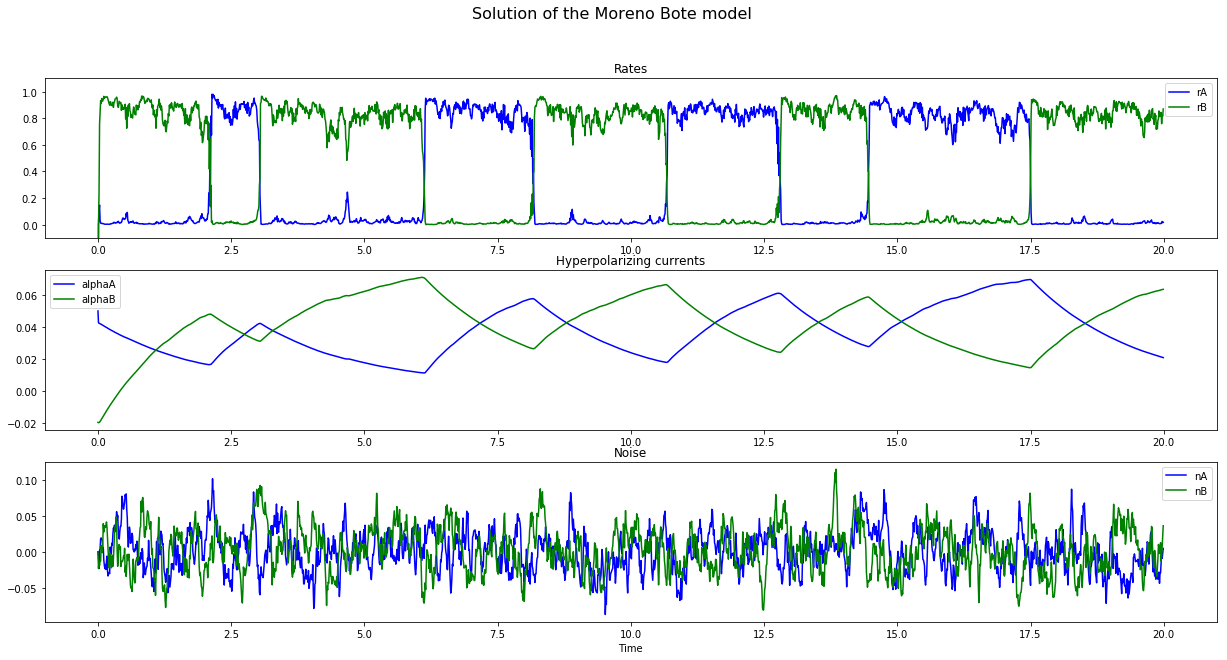

In [21]:
# set parameters
alpha, beta, gamma = 0.75, 0.5, 0.1    
eta = 0.5
gA = gB = 0.05
phi = 0.5
tau = 0.01
tau_s = 0.1
tau_a = tau_b = 2
sigma = 0.03

dt = 0.01
t = np.arange(0, 20, dt)
x0 = [1, 0, 0, 0.01, 0.04, 0]
sol = euler_maruyama(f_moreno_bote, g_moreno_bote, x0, t, **{'sigma':sigma, 'tau_s':tau_s})
plot_moreno_results(sol, t)

In [22]:
score += [3, 3]; score #

array([14., 14.])

Mean durations for gamma=0.1: 2.19ms


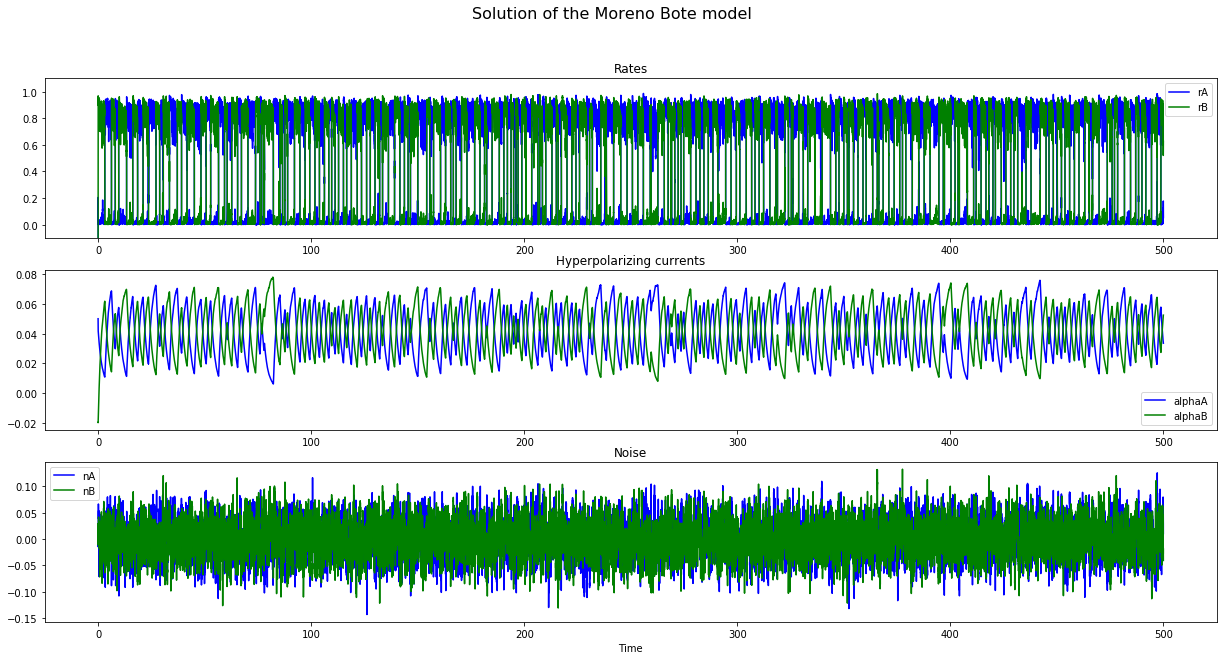

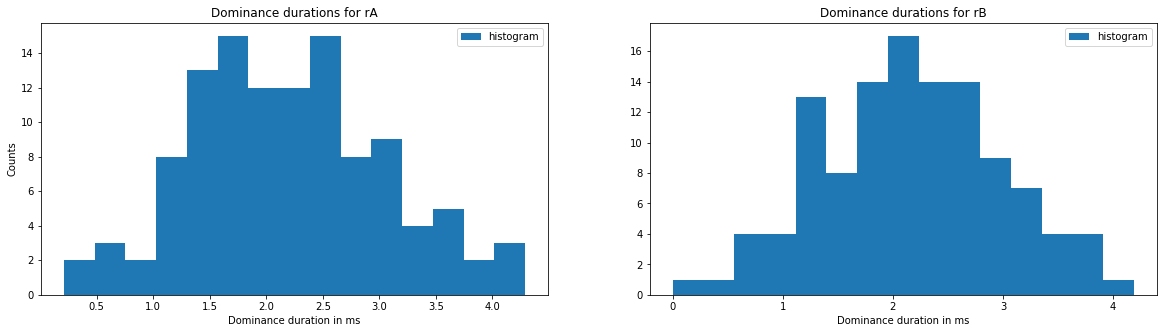

In [23]:
sigma = 0.03
gamma = 0.1
tau_s = 0.1
t = np.arange(0, 500, 0.01)
x0 = [1, 0, 0, 0.01, 0.04, 0]
sol1 = euler_maruyama(f_moreno_bote, g_moreno_bote, x0, t, **{'sigma':sigma, 'tau_s': tau_s})
plot_moreno_results(sol1, t)
plot_duration_hist(sol1[:,0], sol1[:,3])
meanDur1 = np.mean(dominance_durations(sol1[:,0], sol1[:,3],t))
meanDur2 = np.mean(dominance_durations(sol1[:,3], sol1[:,0],t))
print("Mean durations for gamma={}: {}ms".format(gamma, round(np.mean([meanDur1, meanDur2]), 2)))

In [24]:
score += [1, 1]; score #

array([15., 15.])

Mean durations for gamma=0: 3.85ms


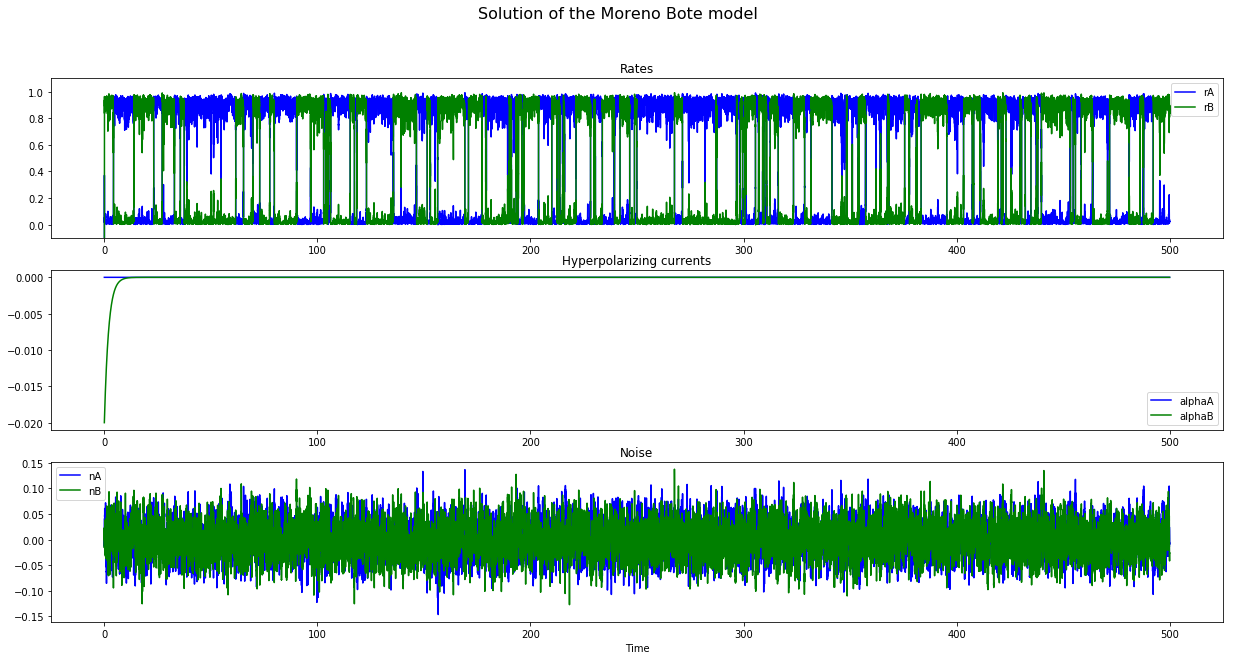

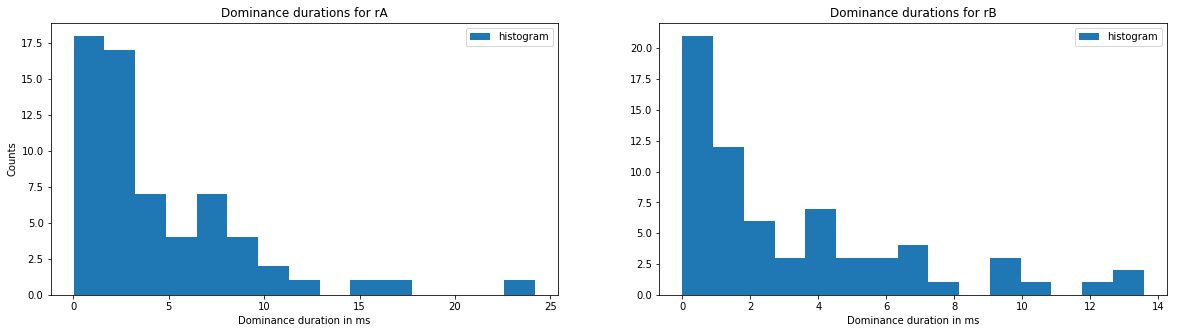

In [25]:
sigma = 0.03
gamma = 0
tau_s = 0.1
t = np.arange(0, 500, 0.01)
x0 = [1, 0, 0, 0.01, 0.04, 0]
sol2 = euler_maruyama(f_moreno_bote, g_moreno_bote, x0, t, **{'sigma':sigma, 'tau_s': tau_s})
plot_moreno_results(sol2, t)
plot_duration_hist(sol2[:,0], sol2[:,3])
meanDur1 = np.mean(dominance_durations(sol2[:,0], sol2[:,3],t))
meanDur2 = np.mean(dominance_durations(sol2[:,3], sol2[:,0],t))
print("Mean durations for gamma={}: {}ms".format(gamma, round(np.mean([meanDur1, meanDur2]), 2)))

#### What is the influence of $\gamma$?
$\gamma$ influences the dominance durations. The smaller it is, the longer the durations. It regulates the intrinsic adaption of the rates. 

#### How and why does the histogram change if you set $\gamma=0$?
In this case less shifts are happening because the inhibitory currents have no positive input so that they just decay to zero exponentially. If there still is a shift then this would be completely noise induced. The histogram will therefore contain many zero duration counts and some very high duration counts because shifts are happening very rarely. 

In [26]:
score += [1, 1]; score # In the purely noise driven case it becomes a Poisson process

array([16., 16.])

In [27]:
# find parameters that fit the above mean durations
sigma = 0.035 # make noise a bit stronger --> more shifts
gamma = 0.0
tau_s = 0.16 # make noise a bit slower --> longer durations
t = np.arange(0, 500, 0.01)
x0 = [1, 0, 0, 0.01, 0.04, 0]
sol3 = euler_maruyama(f_moreno_bote, g_moreno_bote, x0, t, **{'sigma':sigma, 'tau_s':tau_s})
# calculate mean durations 
meanDur1 = np.mean(dominance_durations(sol3[:,0], sol3[:,3],t))
meanDur2 = np.mean(dominance_durations(sol3[:,3], sol3[:,0],t))
print("Mean durations for gamma=0 and noise params: {}".format(np.mean([meanDur1, meanDur2])))

Mean durations for gamma=0 and noise params: 3.174718344155842


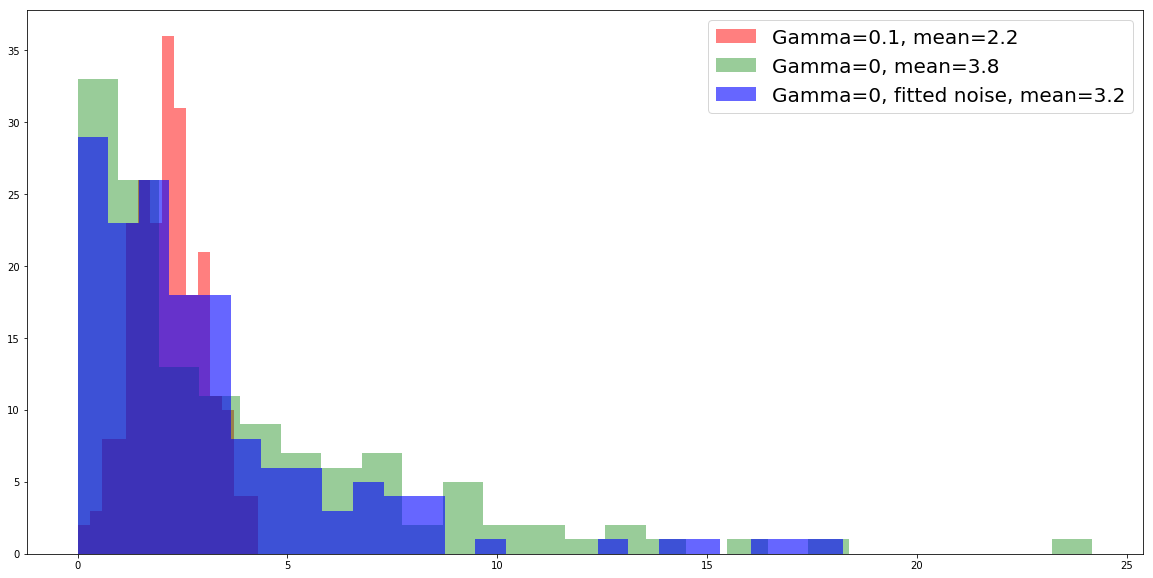

In [28]:
# plot histograms
dur1 = np.append(dominance_durations(sol1[:,0], sol1[:,3],t), dominance_durations(sol1[:,3], sol1[:,0],t))
dur2 = np.append(dominance_durations(sol2[:,0], sol2[:,3],t), dominance_durations(sol2[:,3], sol2[:,0],t))
dur3 = np.append(dominance_durations(sol3[:,0], sol3[:,3],t), dominance_durations(sol3[:,3], sol3[:,0],t))
plt.figure(figsize=(20,10))
plt.hist(dur1, color='r', alpha=.5, bins=15)
plt.hist(dur2, color='g', alpha=.4, bins=25)
plt.hist(dur3, color='b', alpha=.6, bins=25)
plt.legend(["Gamma=0.1, mean={}".format(round(np.mean(dur1),1)), "Gamma=0, mean={}".format(round(np.mean(dur2),1)), "Gamma=0, fitted noise, mean={}".format(round(np.mean(dur3),1))], fontsize=20);

#### How do they differ?

The first histogram (red) of the original setup has a Gaussian shape, so it is symmetric around its mean. The other two are more exponential with long tails. This is due to lack of adaptation if $\gamma=0$. In this scenario switches happen only due noise, i.e., if the noise pushes $r_A$ up and $r_B$ down at the same time and to the right amount. 

In [29]:
score += [2, 2]; score # Great work!

array([18., 18.])